# Standard variational auto-encoder to represent the digits in a 2-dimensional space
We will use this for modelling $P(X)$ and $P(X|T)$.

Note: If you want to run this part, you need to change some things. Comment out the things that mount the Google Drive and refer to/download files from the Drive. This will not work since we have different accounts.

I suggest that you run the second part, which illustrates the findings of the paper.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.


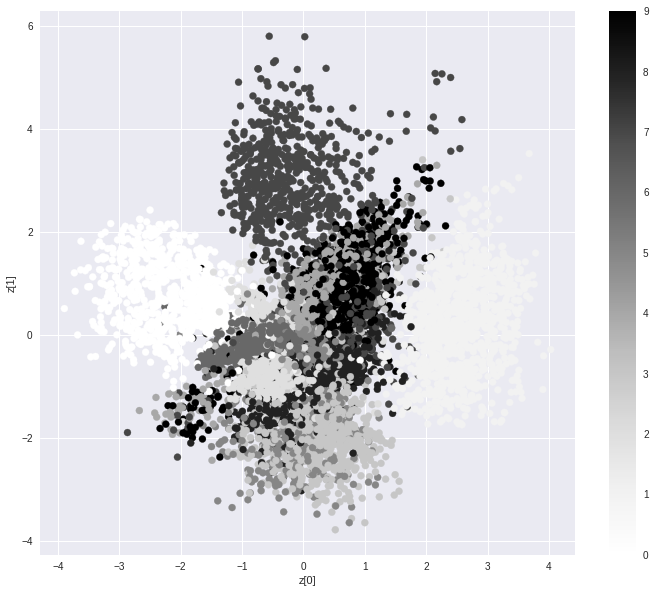

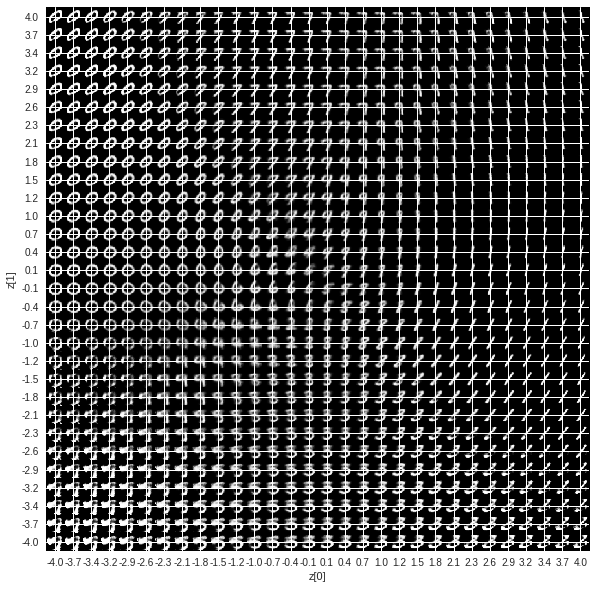

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os; os.environ['KERAS_BACKEND'] = 'theano'
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = binary_crossentropy(inputs,outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

#Load the weights, if they are present
from keras.models import load_model
!pip install GoogleDriveDownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1nrT-kSK3jeeLc_CmTJEXGZuXx4aeSznK',
                                    dest_path='./models/vae.h5', unzip=False)


weights = True
if weights == True:
  vae.load_weights('./models/vae.h5')
else:  
  # train the autoencoder
  vae.fit(x_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_test, None))
  
  #Mount Google drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  vae.save_weights('/content/gdrive/My Drive/julian/models/vae.h5')

plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

# Example of Information Bottleneck analysis (Part 2)


In [0]:
import numpy as np
from random import randint, seed


n_train_samples = 50000 # number of train samples
n_test_samples = 10000 # number of test samples

groups = np.append(np.zeros(8),np.ones(8)) # 16 groups
np.random.seed(1234)
np.random.shuffle(groups)

# generate samples
seed(1234)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # inputs
    x_int = np.zeros(n_samples) # integers representing the inputs
    y_data = np.zeros((n_samples, 2)) # outputs
    
    for i in range(n_samples):
        random_int = randint(0, 1023)
        x_data[i,:] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))]
        x_int[i] = random_int
        y_data[i,0] = groups[random_int % 16]
        y_data[i,1] = 1 - y_data[i,0]
        
    return x_data, y_data, x_int

x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset


In [0]:
import tensorflow as tf

def fully_conn(tensor, n_outputs, name):
    size = tensor.get_shape().as_list()[1]
    
    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)
    
    # hyperbolic tangent activation
    tensor = tf.tanh(tensor, name=name)
    
    return tensor
  
  
  
def output(tensor, n_outputs):
    size = tensor.get_shape().as_list()[1]
    
    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)
    
    return tensor
  
  
def mlp(x, n_neurons): # x is the input layer    
    # hidden layers
    hidden = x
    for n in range(len(n_neurons)):
        hidden = fully_conn(hidden, n_neurons[n], 'hidden%s' % (n+1))
    
    # output layer
    y = output(hidden, 2)
    
    return y
  
  
def build_network(hidden_layer_neurons):
    global x, y, logits, cost, optimizer, accuracy
    
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, (None, 10), name='x')
    y = tf.placeholder(tf.float32, (None, 2), name='y')

    tf.set_random_seed(12345)
    logits = mlp(x, hidden_layer_neurons)
    logits = tf.identity(logits, name='logits')

    # cross-entropy coss function
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y), name='cost')
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
    
    # accuracy
    correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
def print_out_summary(sess, epoch):
    acc, loss = sess.run([accuracy, cost], feed_dict={x: x_test, y: y_test})
    print('Epoch {:>4}:  Testing accuracy {:>.4f} - Testing loss {:>.4f}'.format(epoch, acc, loss))

build_network([8,6,4]) # 3 hidden layers with 8, 6 and 4 neurons respectively

n_epochs = 2000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # initialization
    
    for epoch in range(n_epochs):
        sess.run(optimizer, feed_dict={x: x_train, y: y_train})
        if epoch % 100 == 0: print_out_summary(sess, epoch)

In [0]:
from collections import Counter

pdf_x = Counter(); pdf_y = Counter();
for i in range(n_train_samples):
  pdf_x[x_train_int[i]] += 1/float(n_train_samples) op
  pdf_y[y_train[i,0]] += 1/float(n_train_samples)      

def calc_mutual_information(hidden):
    n_neurons = hidden.shape[1]
  
    # discretization 
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    
    # initialize pdfs
    #pdf_x = Counter(); pdf_y = Counter();
    pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples):
        #pdf_x[x_train_int[i]] += 1/float(n_train_samples)
        #pdf_y[y_train[i,0]] += 1/float(n_train_samples)      
        pdf_xt[(x_train_int[i],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_yt[(y_train[i,0],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1/float(n_train_samples)
    
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    for i in pdf_xt:
        # P(x,t), P(x) and P(t)
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        # I(X;T)
        mi_xt += p_xt * np.log(p_xt / p_x / p_t)
 
    # calculate decoder mutual information I(T;Y)
    mi_ty = 0
    for i in pdf_yt:
        # P(t,y), P(t) and P(y)
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        # I(X;T)
        mi_ty += p_yt * np.log(p_yt / p_t / p_y)
            
    return mi_xt, mi_ty

# get mutual information for all hidden layers
def get_mutual_information(hiddens):
    mi_xt_list = []; mi_ty_list = []
    for hidden in hiddens:
        mi_xt, mi_ty = calc_mutual_information(hidden)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list

In [0]:
def get_hidden_layers(names):
    hidden_layers = []
    for name in names:
        hidden_layers.append(tf.get_default_graph().get_tensor_by_name("%s:0" % name))
    return hidden_layers

# train the neural network and obtain mutual information
def train_with_mi(n_epochs, n_hidden_layers):
    mi_xt_all = []; mi_ty_all = []; epochs = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # initialization
    
        hidden_layer_names = ['hidden%s' % i for i in range(1,n_hidden_layers+1)]
        for epoch in range(n_epochs):
            _, hidden_layers = sess.run([optimizer,
                                         get_hidden_layers(hidden_layer_names)],
                                         feed_dict={x: x_train, y: y_train})
                        
            if epoch % 100 == 0: print_out_summary(sess, epoch)
                
            if epoch % 20 == 0:
                mi_xt, mi_ty = get_mutual_information(hidden_layers)
                mi_xt_all.append(mi_xt)
                mi_ty_all.append(mi_ty)
                epochs.append(epoch)
    
    return np.array(mi_xt_all), np.array(mi_ty_all), np.array(epochs)

n_epochs = 3000
n_hidden_layers = 3
mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((3,7))
ax.set_ylim((0.1,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)


cmap = plt.cm.get_cmap('cool')

def animate(i):
    title.set_text('Epoch %s' % str(epochs[i]).zfill(4))
    ax.plot(mi_xt_all[i,:], mi_ty_all[i,:], 'k-',alpha=0.2)
    if i > 0:
        for j in range(n_hidden_layers):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j],'.-',c=cmap(j*.2),ms=10)
    return

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)

rc('animation', html='jshtml')
anim

#ax.set_title('Epoch 0000 - 2999')
#fig # show full evolution process

# Apply Information Bottleneck Analysis to MNIST data

In [0]:
from keras.utils import to_categorical

#Get the data:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [19]:
import tensorflow as tf

def fully_conn(tensor, n_outputs, name):
    size = tensor.get_shape().as_list()[1]
    
    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)
    
    # hyperbolic tangent activation
    tensor = tf.tanh(tensor, name=name)
    
    return tensor
  
  
  
def output(tensor, n_outputs):
    size = tensor.get_shape().as_list()[1]
    
    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))
    
    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)
    
    return tensor
  
  
def mlp(x, n_neurons): # x is the input layer    
    # hidden layers
    hidden = x
    for n in range(len(n_neurons)):
        hidden = fully_conn(hidden, n_neurons[n], 'hidden%s' % (n+1))
    
    # output layer
    y = output(hidden, 10)
    
    return y
  
  
def build_network(hidden_layer_neurons):
    global inputs, outputs, logits, cost, optimizer, accuracy, isTrain
    
    tf.reset_default_graph()
    
    inputs = tf.placeholder(tf.float32, shape=(None, 784), name='inputs')
    outputs = tf.placeholder(tf.float32, shape=(None,), name='outputs')
    isTrain = tf.placeholder(tf.bool, shape=())
    
    #Prepare a tensorflow dataset
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    
    ds = ds.shuffle(buffer_size=10, reshuffle_each_iteration=True).batch(batch_size=batch_size, drop_remainder=True).repeat()
    iter = ds.make_one_shot_iterator()
    next = iter.get_next()
    
    def usetrain():
      inputs = next[0]
      outputs = next[1]
      return inputs, outputs
    def usetest():
      return x_test, y_test

    
    inputs, outputs = tf.cond(isTrain, usetrain, usetest)
    

    tf.set_random_seed(12345)
    logits = mlp(inputs, hidden_layer_neurons)
    logits = tf.identity(logits, name='logits')    

    # cross-entropy coss function
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=outputs), name='cost')
    
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
    
    # accuracy
    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(logits, 1), name='correct_prediction')
    accuracy = tf.multiply(tf.reduce_mean(tf.cast(correct_prediction, "float")),tf.constant(100.0),name='accuracy')
    
    
def print_out_summary(sess, epoch):
    acc, loss = sess.run([accuracy, cost], feed_dict={isTrain: False})
    print('Epoch {:>4}:  Testing accuracy {:>.4f} - Testing loss {:>.4f}'.format(epoch, acc, loss))

build_network([20,20,20,20])

n_epochs = 2
batch_size = 1000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # initialization
    for epoch in range(n_epochs):
      for i in range(int(x_train.shape[0]/batch_size)):
        sess.run([optimizer], feed_dict={isTrain: True})
       
      print_out_summary(sess, epoch)
        
            

Epoch    0:  Testing accuracy 11.5900 - Testing loss 0.7333
Epoch    1:  Testing accuracy 12.8600 - Testing loss 0.5183


In [0]:
from collections import Counter
from scipy import stats

#Get the latent variables of x_train
z, _, _ = encoder.predict(x_train, batch_size=batch_size)
y_dense = np.argmax(y_train,axis=1)
num_examples = float(len(y_dense))

#Bin the values of z, x = z[:,0] & y = z[:,1]
num_bins = 64 #4096 bins
x_edge = np.linspace(min(z[:,0]), max(z[:,0]), num=num_bins)
y_edge = np.linspace(min(z[:,1]), max(z[:,1]), num=num_bins)

statistic, _, _, binnumber = stats.binned_statistic_2d(z[:,0], z[:,1], values=None, statistic = 'count', bins = [x_edge,y_edge], expand_binnumbers = True)
statistic = statistic/num_examples

pdf_x = Counter(); pdf_y = Counter();
for i in range(statistic.shape[0]):
  for j in range(statistic.shape[1]):
    pdf_x[(i,j)] = statistic[i,j]
    
for i in range(len(y_dense)):
    pdf_y[y_dense[i]] += 1/float(num_examples)

assert(np.round(sum(pdf_x.values()),2) == 1) #Must be a valid pdf
assert(np.round(sum(pdf_y.values()),2) == 1)

num_examples = int(num_examples)

    
def calc_mutual_information(hidden):
  
    # discretization 
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    num_examples = hidden.shape[0]
    
    # initialize pdfs
    pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()
    #Get the binnumbers of all z
    _,_,_,binnumber = stats.binned_statistic_2d(z[:,0], z[:,1], values=None, statistic = 'count', bins = [x_edge,y_edge], expand_binnumbers = True)
    for i in range(num_examples):
      #Get bin coordinate
      bin_c = (binnumber[0,i]-1, binnumber[1,i]-1) #bin numbers start at 1.
      pdf_xt[bin_c+tuple(indices[i,:])] += 1/float(num_examples)
      pdf_yt[(y_dense[i],)+tuple(indices[i,:])] += 1/float(num_examples)
      pdf_t[tuple(indices[i,:])] += 1/float(num_examples)
    
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    for i in pdf_xt:
        # P(x,t), P(x) and P(t)
        p_xt = pdf_xt[i]; p_x = pdf_x[(i[0],i[1])]; p_t = pdf_t[i[2:]]
        # I(X;T)
        mi_xt += p_xt * np.log(p_xt / (p_x+1e-12) / (p_t+1e-12)) #Or remove the zeros?
 
    # calculate decoder mutual information I(T;Y)
    mi_ty = 0
    for i in pdf_yt:
        # P(t,y), P(t) and P(y)
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        # I(X;T)
        mi_ty += p_yt * np.log(p_yt / p_t / p_y)
            
    return mi_xt, mi_ty

# get mutual information for all hidden layers
def get_mutual_information(hiddens):
    mi_xt_list = []; mi_ty_list = []
    for hidden in hiddens:
        mi_xt, mi_ty = calc_mutual_information(hidden)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list

In [0]:
def get_hidden_layers(names):
    hidden_layers = []
    for name in names:
        hidden_layers.append(tf.get_default_graph().get_tensor_by_name("%s:0" % name))
    return hidden_layers

# train the neural network and obtain mutual information
def train_with_mi(n_epochs, n_hidden_layers):
    mi_xt_all = []; mi_ty_all = []; epochs = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # initialization
    
        hidden_layer_names = ['hidden%s' % i for i in range(1,n_hidden_layers+1)]
        for epoch in range(n_epochs):
          for i in range(int(x_train.shape[0]/batch_size)):
            _, hidden_layers = sess.run([optimizer,
                                         get_hidden_layers(hidden_layer_names)],
                                        feed_dict={isTrain: True})
                        
          if epoch % 100 == 0: print_out_summary(sess, epoch)
          
          if epoch % 20 == 0:
            mi_xt, mi_ty = get_mutual_information(hidden_layers)
            mi_xt_all.append(mi_xt)
            mi_ty_all.append(mi_ty)
            epochs.append(epoch)
    
    return np.array(mi_xt_all), np.array(mi_ty_all), np.array(epochs)

n_epochs = 4000
n_hidden_layers = 4
mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)

Epoch    0:  Testing accuracy 11.5900 - Testing loss 0.7333
Epoch  100:  Testing accuracy 50.5300 - Testing loss 0.2200
Epoch  200:  Testing accuracy 63.2700 - Testing loss 0.1758
Epoch  300:  Testing accuracy 69.0800 - Testing loss 0.1530
Epoch  400:  Testing accuracy 73.1800 - Testing loss 0.1378
Epoch  500:  Testing accuracy 76.2300 - Testing loss 0.1260
Epoch  600:  Testing accuracy 78.8200 - Testing loss 0.1169
Epoch  700:  Testing accuracy 80.6200 - Testing loss 0.1097
Epoch  800:  Testing accuracy 81.9100 - Testing loss 0.1045
Epoch  900:  Testing accuracy 82.8700 - Testing loss 0.1002
Epoch 1000:  Testing accuracy 83.6500 - Testing loss 0.0961


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((5.5,7))
ax.set_ylim((2.0,2.3))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)


cmap = plt.cm.get_cmap('cool')

def animate(i):
    title.set_text('Epoch %s' % str(epochs[i]).zfill(4))
    ax.plot(mi_xt_all[i,:], mi_ty_all[i,:], 'k-',alpha=0.2)
    if i > 0:
        for j in range(n_hidden_layers):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j],'.-',c=cmap(j*.2),ms=10)
    return

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)

rc('animation', html='jshtml')
anim

#ax.set_title('Epoch 0000 - 2999')
#fig # show full evolution process

In [7]:
!git clone https://github.com/gregversteeg/NPEET.git
%cd NPEET/npeet
!ls

Cloning into 'NPEET'...
remote: Enumerating objects: 73, done.
remote: Total 73 (delta 0), reused 0 (delta 0), pack-reused 73
Unpacking objects: 100% (73/73), done.
/content/NPEET/NPEET/NPEET/npeet
entropy_estimators.py  __init__.py


In [13]:
import numpy as np
import entropy_estimators as ee
x = np.random.normal(np.zeros(10),np.ones(10),[10000,10])
y = x + np.random.normal(np.zeros(10),np.ones(10)*np.sqrt(0.2), [10000,10])
ee.mi(x,y)

5.956257687181569